# Nature CNN Recreation

In [1]:
%cd ..

/home/marcusp/Documents/traffic-sign-classification


## Data

In [2]:
from dataio.gtsrb_dataset import GTSRBDataset
import numpy as np

chosen_classes = {1, 2, 10, 13, 38}
labels = GTSRBDataset().labels_data

# Filter indices for chosen classes.
filtered_indices = [i for i, (_, label) in enumerate(labels) if label in chosen_classes]

# Group indices by class.
class_indices = {class_label: [] for class_label in chosen_classes}
for index in filtered_indices:
    _, label = labels[index]
    if label in chosen_classes:
        class_indices[label].append(index)

# Clip each class to 2500 images and combine.
clipped_indices = []
for label in chosen_classes:
    indices = class_indices[label]
    if len(indices) > 2500:
        indices = np.random.choice(indices, size=2500, replace=False)
    clipped_indices.extend(indices)

# Shuffle the clipped indices.
clipped_indices = np.array(clipped_indices)
np.random.shuffle(clipped_indices)

# Split into training and testing sets.
# The original Dataset had an approximate 85-15 split - no validation set.
dataset_length = len(clipped_indices)
train_split = clipped_indices[:int(0.85 * dataset_length)]
test_split = clipped_indices[int(0.15 * dataset_length):]

In [3]:
from dataio.transforms import ToCompose, ToGrayscale, ToResize, ToTensor, ToNormalize

# Set up the data transformations to match the original nature CNN.
train_transforms = ToCompose([
    ToGrayscale(),
    ToResize(size=28),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

val_transforms = ToCompose([
    ToGrayscale(),
    ToResize(size=28),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

from dataio.dataloader import DataLoader

# Set up the datasets.
train_dataset = GTSRBDataset(
    indices=train_split,
    split="train",
    transforms=train_transforms
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = GTSRBDataset(
    indices=test_split,
    split="test",
    transforms=val_transforms
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Architecture

In [4]:
from nn.layers.conv2d import Conv2D
from nn.layers.flatten import Flatten
from nn.layers.linear import Linear
from nn.layers.maxpool2d import MaxPool2D
from nn.layers.sequential import Sequential
from nn.layers.activation import Activation
from nn.activations import sigmoid

# Set up model, matching the original CNN as best as possible.
layers = [
    Conv2D(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
    Activation(sigmoid),
    MaxPool2D(pool_size=2, stride=2),
    Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    Activation(sigmoid),
    MaxPool2D(pool_size=2, stride=2),
    Flatten(),
    Linear(in_features=256, out_features=120),
    Activation(sigmoid),
    Linear(in_features=120, out_features=84),
    Activation(sigmoid),
    Linear(in_features=84, out_features=43)
]

model = Sequential(layers)

In [5]:
# Get the parameters from the model.
param_dict = {}
for layer in model.layers:
    param_list = layer.params()
    param_dict.update(param_list)

from nn.optim import Momentum

# Initialise the optimiser.
# The original CNN used SGD with Momentum.
optimizer = Momentum(param_dict, lr=0.001, weight_decay=0.0005)

from nn.loss import mse

# Define the loss function.
loss_fn = mse

## Training

In [6]:
from train import train

# Train the model.
train_losses, _, train_accs, _ = train(
    model,
    train_loader,
    val_loader=None,
    loss_fn=loss_fn,
    optimiser=optimizer,
    num_epochs=30
)

## Evaluation

In [7]:
from evaluate import evaluate

# Evaluate the model.
test_loss, test_acc = evaluate(model, test_loader, loss_fn)

Test Loss: 341.0943, Test Accuracy: 0.2005


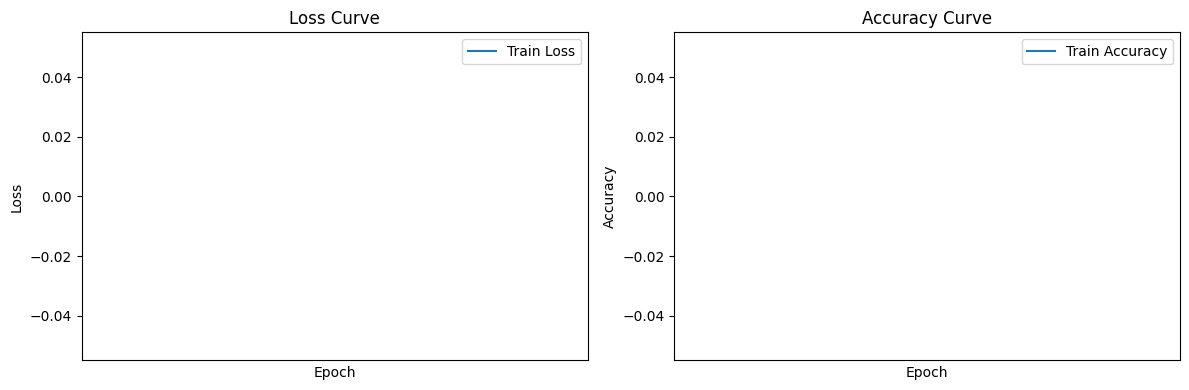

In [16]:
import viz
import importlib
importlib.reload(viz)
viz.plot_curves(train_losses, train_accs)

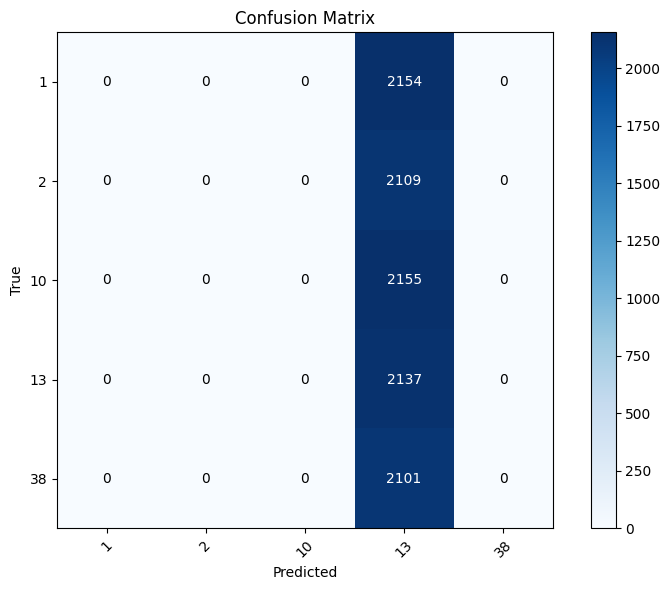

In [17]:
# Collect all true labels and predictions.
all_true_labels = []
all_predictions = []

for batch_data, batch_labels in test_loader:
    predictions = np.argmax(model.forward(batch_data), axis=1)
    all_true_labels.extend(batch_labels)
    all_predictions.extend(predictions)

# Filter the true labels and predictions to include only the classes of interest.
filtered_true_labels = []
filtered_predictions = []

for true, pred in zip(all_true_labels, all_predictions):
    if true in chosen_classes and pred in chosen_classes:
        filtered_true_labels.append(true)
        filtered_predictions.append(pred)

# Plot the confusion matrix using the filtered data.
viz.plot_confusion_matrix(
    np.array(filtered_true_labels),
    np.array(filtered_predictions),
    chosen_classes
)


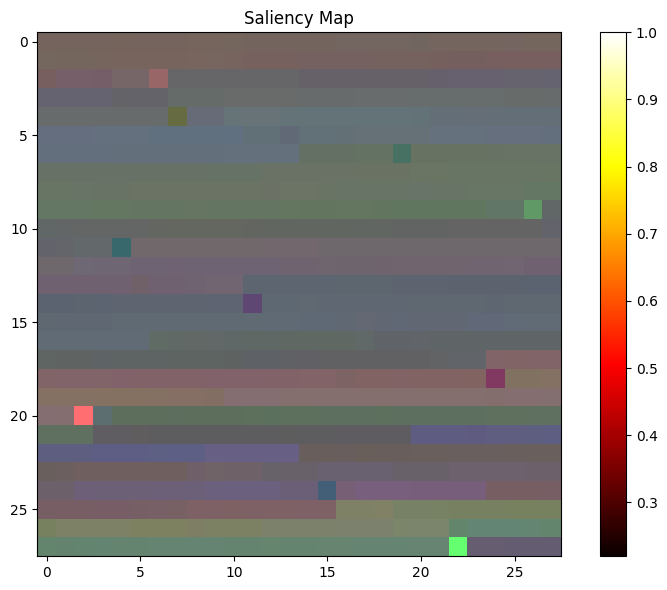

In [18]:
# Produce a saliency map.
for batch_data, batch_labels in test_loader:
    # Iterate over each sample in the batch
    for i in range(batch_data.shape[0]):
        input_sample = batch_data[i]  # Shape should be (C, H, W)
        saliency_map = viz.compute_saliency_map(model, input_sample)
        viz.plot_saliency_map(saliency_map)
        break  # Remove this break to process more than one sample
    break  # Remove this break to process more than one batch
